# An Introduction to Word Embeddings

One of the breakthroughs in Natural Language Processing is the usage of word embeddings. Rather than using the words themselves as features, neural network methods typically take as input dense, relatively low-dimensional vectors that model the meaning and usage of a word. Word embeddings were first popularized through the [Word2Vec](https://arxiv.org/abs/1301.3781) model, developed by Thomas Mikolov and colleagues at Google. Since then, scores of alternative approaches have been developed, such as [GloVe](https://nlp.stanford.edu/projects/glove/) and [FastText](https://fasttext.cc/) embeddings. In this notebook, we'll explore word embeddings with the original Word2Vec approach, as implemented in the [Gensim](https://radimrehurek.com/gensim/) library.

Modified from: https://github.com/nlptown/nlp-notebooks/blob/master/An%20Introduction%20to%20Word%20Embeddings.ipynb

## Training word embeddings

To train word embedings, we need to compile a corpus of text that captures the meaning and usage of words in a particular dialect. Wikipedia is a good choice for training generic embeddings representing the proper use of different languages. For our experiments, however, we're going to use scraped comments from [r/aww](https://www.reddit.com/r/aww/), a subreddit of "Things that make you go AWW! Like puppies, bunnies, babies and so on".

We've collected and lowercased a collection of 6 months of comments from this subreddit using the scripts in the notebook `0.Data Scraping and Prep`.

Each entry in this file represents one comment in one post from that subreddit.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

class SentenceCorpus(object):

    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        with open(self.filename, "r") as i:
            for line in i:
                tokens = line.strip().split()
                yield tokens

# This command will unzip the text file
# The rest of the cell will run even if this command fails
!gzip -d ../data/reddit_aww_comments.csv.gz
                
TEXT_FILE = '../data/reddit_aww_comments.csv'
sentences = SentenceCorpus(TEXT_FILE)

When training word embeddings, Gensim allows the user to set a number of parameters. The most important are:

- `min_count` is the **minimum frequency of the words** in our corpus. For infrequent words, we just don't have enough information to train reliable word embeddings. It therefore makes sense to set this minimum frequency to at least 10.


- `window` is **number of words to the left and to the right that make up the context for the word** that word2vec will take into account.


- `size` is the **dimensionality of the word vectors**. This is generally between 100 and 1000. You often have to make a trade-off: embeddings with a higher dimensionality are able to model more information, but also need more data to train.


- `sg`: there are two **algorithms to train word2vec**: skip-gram and CBOW. Skip-gram tries to predict the context on the basis of the target word; CBOW tries to find the target on the basis of the context. By default, Gensim uses CBOW (`sg=0`).

In [2]:
import gensim
model = gensim.models.Word2Vec(sentences, min_count=25, window=5, size=100)

## Using word embeddings

Let's take a look at the model. The word embeddings are on the `wv` attribute of the model. We can access them by the using the token as key. The vocabulary includes any token that occurs more than `min_count` times in the document, including frequent mispellings and emojis. For example, here is the embedding for the emoji 😍:

In [3]:
model.wv["😍"]

array([-0.00941202,  0.36298957, -0.1909867 ,  0.5893947 , -0.66679424,
       -0.2802342 ,  0.19007355,  0.15974477, -0.04760361,  1.0663468 ,
        0.6925546 ,  0.41432223, -0.83685315,  0.10885751, -0.18643409,
       -0.74849993,  0.15565476, -0.4775012 , -0.09293415,  0.14949353,
        0.38822398,  0.29686233, -0.5859575 , -0.4779998 ,  0.0270781 ,
       -0.05783816,  0.20002374, -0.03424821,  0.65973395, -0.5211517 ,
        0.57270473,  0.32279438,  0.8335409 ,  0.14091098, -0.6057591 ,
       -0.2087041 , -0.20369844,  0.2642837 , -0.45868567,  0.5541541 ,
        0.29614934, -0.0498943 ,  0.41729048,  0.3437164 ,  0.04227963,
        0.413365  , -0.12759942, -0.45996875,  0.98622817, -0.36233935,
       -0.18575358, -0.36443898, -0.37427402, -0.30821073, -0.37489238,
       -0.44629776, -0.33373258,  0.37814552, -0.21927339,  0.2786443 ,
        0.05323917, -0.4010215 , -0.10032909,  0.60325354,  0.9594123 ,
        0.13390122,  1.0765249 , -0.13631368,  0.1598686 , -0.44

We can easily find the **similarity between two words** using word embeddings. Similarity is measured as the cosine between the two vectors and ranges between -1 and +1. The higher the cosine, the more similar two words are. As expected, the figures below show that *dog* is closer to *cat* than to *bird*, since variations of the phrase *dogs and cats* are common.

In [4]:
print(model.wv.similarity("dog", "cat"))
print(model.wv.similarity("dog", "bird"))

0.8818363
0.5545852


In a similar vein, we can find the **words that are most similar to a target word**. The words with the closest embedding to *doggo* (lolspeak for *dog*) are for words with similar meaning and use (such as *pupper* and *pup*).

In [5]:
model.wv.similar_by_word("doggo", topn=10)

[('pupper', 0.8756361603736877),
 ('boi', 0.8182311058044434),
 ('boye', 0.7608437538146973),
 ('painting', 0.750678539276123),
 ('doggie', 0.7278278470039368),
 ('boy', 0.7247025966644287),
 ('job', 0.7100133299827576),
 ('choice', 0.7077147960662842),
 ('pup', 0.6960697174072266),
 ('meal', 0.6894614100456238)]

Interestingly, we can look for **words that are similar to a set of words and dissimilar to another set of words** at the same time. This allows us to look for analogies of the type *kitten is to cat what ... is to dog*.

In [6]:
model.wv.most_similar(positive=['puppy', 'cat'], negative=["dog"], topn=10)

[('kitten', 0.7433018088340759),
 ('kitty', 0.723139226436615),
 ('jack', 0.6359173059463501),
 ('lab', 0.6336137056350708),
 ('tabby', 0.6186122298240662),
 ('beagle', 0.6134034395217896),
 ('pup', 0.6016397476196289),
 ('husky', 0.5931851863861084),
 ('black', 0.5818745493888855),
 ('dachshund', 0.5810506343841553)]

We can use embeddings to **explore the meaning of words**. The word *puppy* is very similar to *pup*, a diminutive of the word, and also similar to *kitten*, another young animal:

In [8]:
model.wv.most_similar(positive=["puppy"], topn=10)

[('kitty', 0.7504316568374634),
 ('kitten', 0.7418915629386902),
 ('pup', 0.6961734890937805),
 ('beagle', 0.6398003101348877),
 ('cat', 0.6278865337371826),
 ('girl', 0.6064454317092896),
 ('lab', 0.5972940921783447),
 ('golden', 0.5837888717651367),
 ('husky', 0.5775509476661682),
 ('dog', 0.5768111944198608)]

We can get other details behind the **meaning of words** by looking at words that are similar to *puppy* but don't refer to a *dog*. In comments from `r/aww`, people commonly say that puppies are little, lovable and fuzzy.

In [13]:
model.wv.most_similar(positive=["puppy"], negative=["dog"], topn=10)

[('lil', 0.5835269689559937),
 ('lt', 0.5759639739990234),
 ('❤️', 0.5689661502838135),
 ('❤', 0.5532113313674927),
 ('😍', 0.5530210137367249),
 ('💕', 0.5350375175476074),
 ('eyed', 0.5239102840423584),
 ('tiny', 0.5106654167175293),
 ('🐾', 0.5096805095672607),
 ('fluffy', 0.5066770315170288)]

Finally, use word embeddings to identify **the word in a list that is least similar to the others**:

In [14]:
print(model.wv.doesnt_match("elephant cat cheese mouse".split()))
print(model.wv.doesnt_match("sky bird sun stars".split()))

cat
bird


## Plotting embeddings

Word embeddings are high-dimensional vectors. In this example, our word embeddings have 100 dimensions. There is no hierarchy in the explanatory power of each dimension so we can't simply plot the first two or three dimensions and expect to see significant patterns.

To plot embeddings with high dimensionality, we first need to map them to a dimensionality of 2. We do this with the popular [t-SNE](https://lvdmaaten.github.io/tsne/) method. T-SNE, short for **t-distributed Stochastic Neighbor Embedding**, helps us visualize high-dimensional data by mapping similar data to nearby points and dissimilar data to distance points in two-dimensional space.

T-SNE is available in [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). To run it, we just have to specify the number of dimensions we'd like to map the data to (`n_components`), and the similarity metric that t-SNE should use to compute the similarity between two data points (`metric`). We're going to map to 2 dimensions and use the cosine as our similarity metric. Additionally, we use PCA as an initialization method to remove some noise and speed up computation. The [Scikit-learn user guide](https://scikit-learn.org/stable/modules/manifold.html#t-sne) contains some additional tips for optimizing performance. 

Plotting all the embeddings in our vector space (all of the words in the vocabulary) would result in a very crowded figure. Therefore we'll focus on a subset of embeddings by selecting the 200 most similar words to a target word. 

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

target_word = "husky"
selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=100)]
embeddings = [model.wv[w] for w in selected_words]

mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)

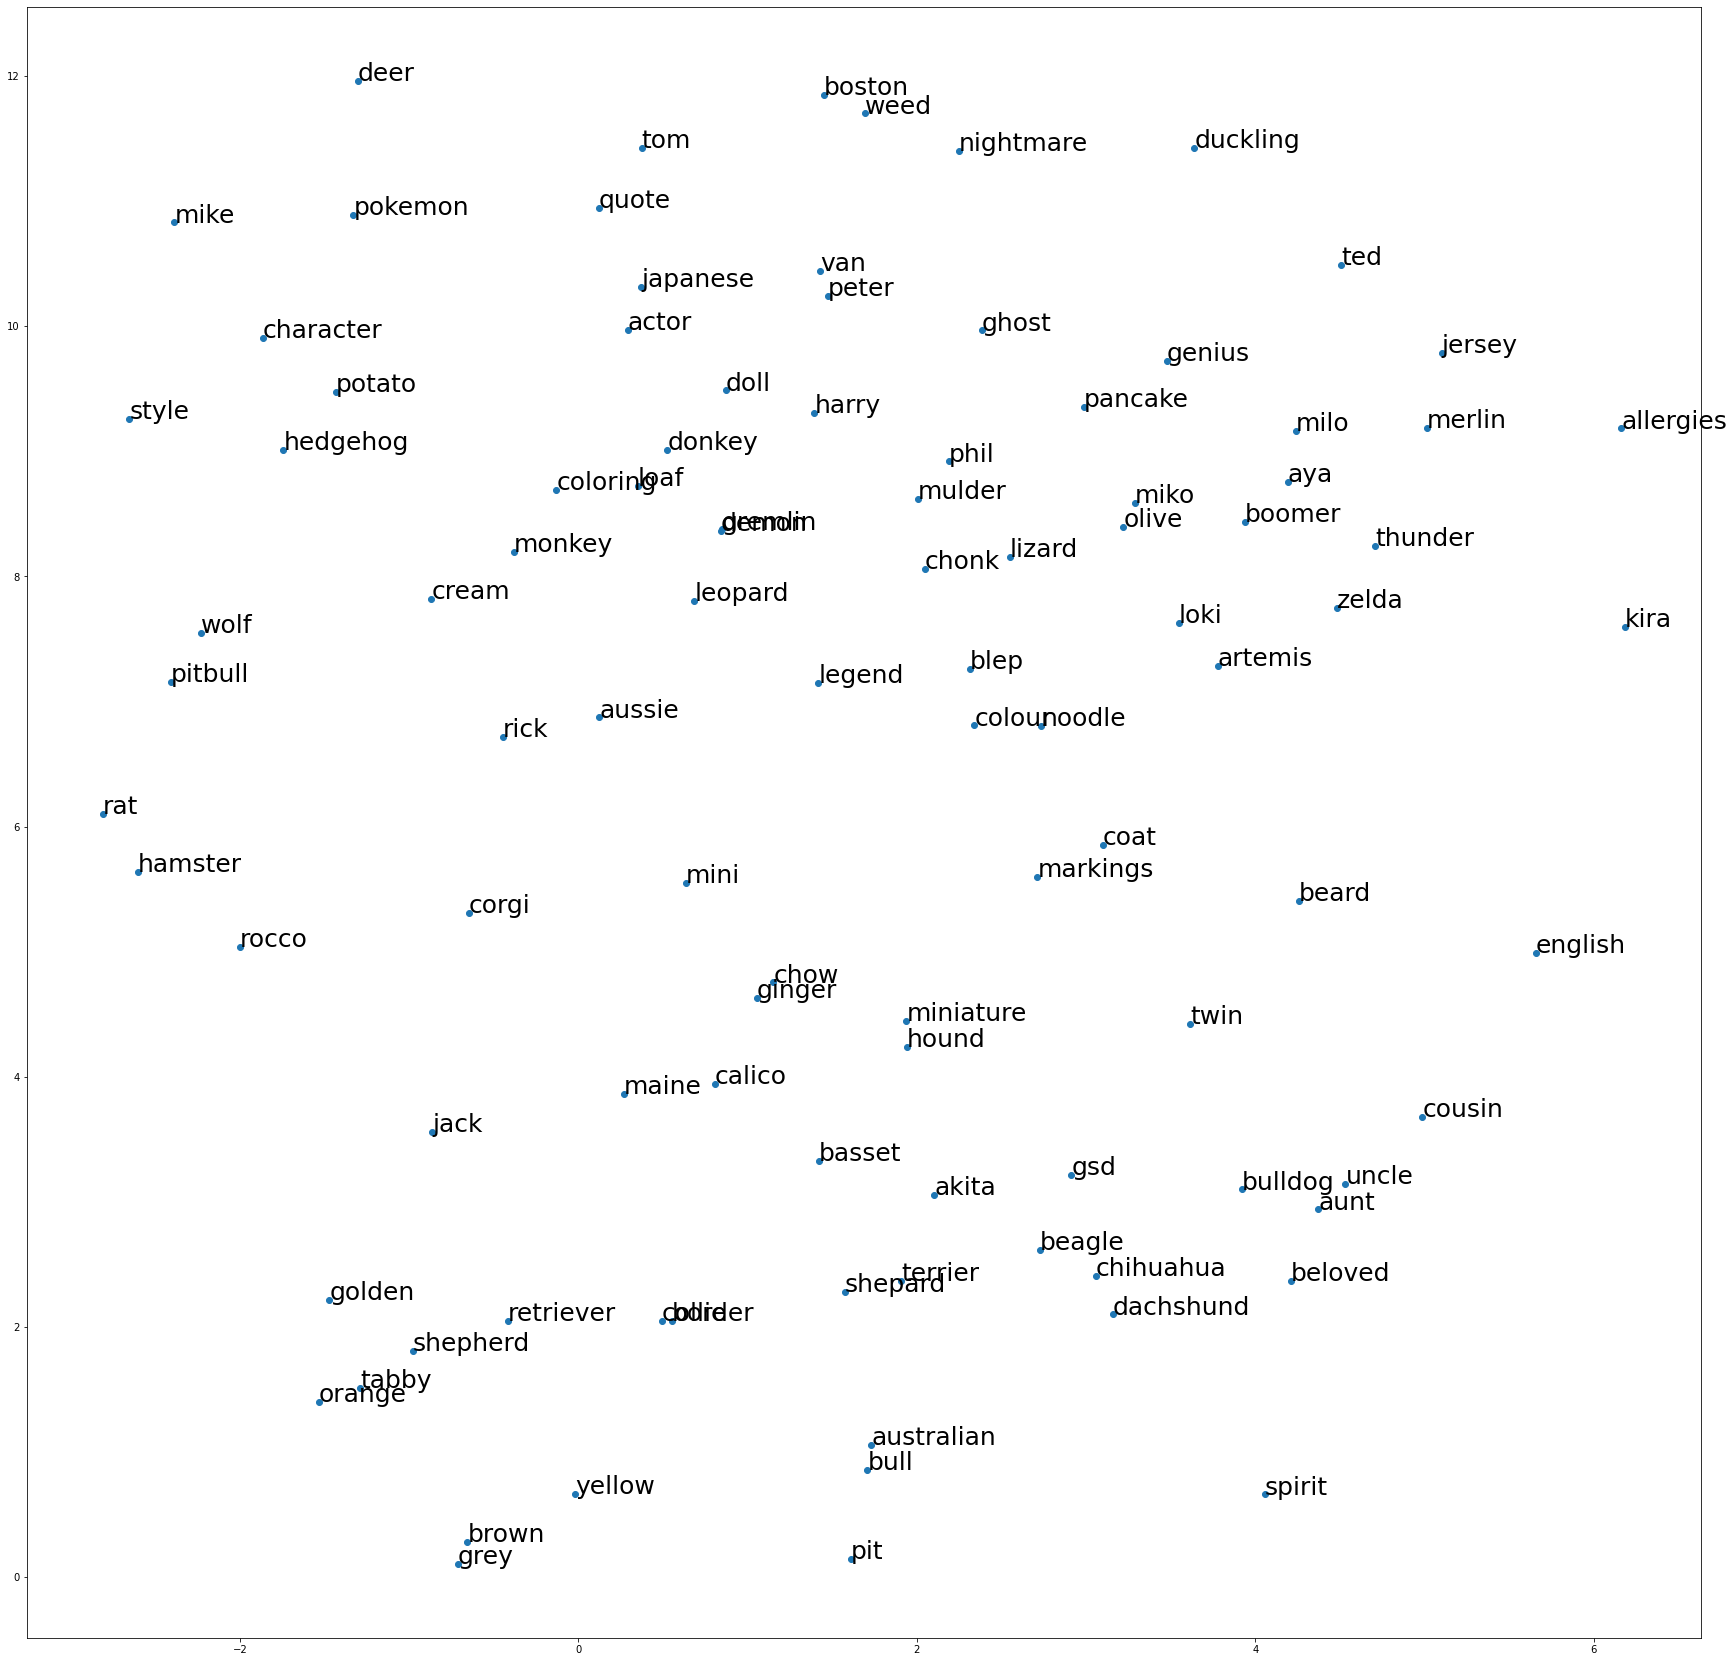

In [16]:
plt.figure(figsize=(30,30))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]), size=25)

## Clustering embeddings

Finally, we're going to cluster our embeddings. We'll use agglomerative clustering, a bottom-up clustering method that iteratively takes together the two most similar clusters (or embeddings) in the data.

In [17]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

vocab = list(model.wv.vocab)
vectors = [model.wv[w] for w in vocab]
vectors_norm = normalize(vectors)

clusterer = AgglomerativeClustering(n_clusters=500)
clusters = clusterer.fit_predict(vectors_norm)


In [18]:
cluster_dictionary = {}
for cluster, word in zip(clusters, vocab): 
    if cluster not in cluster_dictionary:
        cluster_dictionary[cluster] = []
    cluster_dictionary[cluster].append(word)

In [21]:
for x in cluster_dictionary:
    if "beans" in cluster_dictionary[x]:
        print(cluster_dictionary[x])

['toe', 'pink', 'bow', 'tie', 'murder', 'beans']


## Conclusions

Word embeddings are one of the most exciting trends on Natural Language Processing since the 2000s. They allow us to model the meaning and usage of a word, and discover words that behave similarly. This is crucial for the generalization capacity of many machine learning models. Moving from raw strings to embeddings allows them to generalize across words that have a similar meaning, and discover patterns that had previously escaped them.